In [1]:
import torch
torch.set_float32_matmul_precision('high')
torch._dynamo.config.suppress_errors = True

In [23]:
import os
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from collections import Counter
from torch.optim.lr_scheduler import OneCycleLR
import torch_optimizer as optim_advanced
import matplotlib.pyplot as plt

In [3]:
# --- Setup
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
OUT_DIR = "/content/flight_optuna_best"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Synthetic balanced dataset
N_SEQ, TIMESTEPS, FEATURES = 8000, 60, 7
def generate_sequence(is_incident, timesteps=60):
    t = np.linspace(0,1,timesteps)
    alt = 10000 + 200*np.sin(2*np.pi*t) + np.random.normal(0,8,timesteps)
    spd = 250 + 8*np.cos(2*np.pi*t) + np.random.normal(0,3,timesteps)
    pitch, roll, yaw = np.random.normal(0,0.8,timesteps), np.random.normal(0,0.8,timesteps), np.random.normal(0,0.5,timesteps)
    eng, thrust = 200+np.random.normal(0,2,timesteps), 70+np.random.normal(0,2,timesteps)
    seq = np.vstack([alt,spd,pitch,roll,yaw,eng,thrust]).T
    weather, phase, maint = random.choice(["clear","rain","storm","fog","turbulence"]), random.choice(["cruise","takeoff","landing","climb","descent"]), np.random.randint(0,3)
    if is_incident:
        pat = random.choice(["rapid_descent","stall","engine_fail"])
        if pat=="rapid_descent": seq[:,0]-=np.linspace(0,np.random.randint(1000,1500),timesteps)
        if pat=="stall": seq[:,1]-=np.linspace(0,np.random.randint(60,120),timesteps); seq[:,2]+=np.linspace(0,np.random.randint(4,8),timesteps)
        if pat=="engine_fail": seq[:,5]+=np.linspace(0,np.random.randint(100,150),timesteps); seq[:,6]-=np.linspace(0,np.random.randint(30,50),timesteps)
        maint+=np.random.randint(1,2); weather=random.choice(["storm","turbulence","fog"])
    return seq, weather, phase, maint, int(is_incident)

seqs, metas, labels = [], [], []
for i in tqdm(range(N_SEQ)):
    seq,w,p,m,y = generate_sequence(i>=N_SEQ//2)
    seqs.append(seq); metas.append((w,p,m)); labels.append(y)
seqs=np.array(seqs); metas=pd.DataFrame(metas,columns=["weather","phase","maint"]); labels=np.array(labels)

  0%|          | 0/8000 [00:00<?, ?it/s]

100%|██████████| 8000/8000 [00:01<00:00, 7571.63it/s]


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, accumulation_steps=4):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    optimizer.zero_grad(set_to_none=True)

    for i, (sequences, metadata, labels) in enumerate(dataloader):
        sequences = sequences.to(device)
        metadata = metadata.to(device)
        labels = labels.to(device).unsqueeze(1)

        # Forward pass
        outputs = model(sequences, metadata)
        loss = criterion(outputs, labels)

        # Normalize loss for gradient accumulation
        loss = loss / accumulation_steps
        loss.backward()

        # Update weights every `accumulation_steps` batches
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

        # Scale loss back for logging
        total_loss += loss.item() * accumulation_steps

        # Compute accuracy
        preds = (torch.sigmoid(outputs) > 0.4794).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Handle remaining gradients if dataset size not divisible by accumulation_steps
    if total % accumulation_steps != 0:
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad(set_to_none=True)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


In [6]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_probs = []
    all_labels = []

    with torch.inference_mode():
        for sequences, metadata, labels in dataloader:
            sequences = sequences.to(device)
            metadata = metadata.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(sequences, metadata)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            predictions = (probs > 0.65).float()

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(probs.cpu().numpy().flatten().tolist())
            all_labels.extend(labels.cpu().numpy().flatten().tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy, np.array(all_probs), np.array(all_labels)

In [7]:
N, T, F = seqs.shape
print(f"Data shape: {N} samples, {T} timesteps, {F} features")

Data shape: 8000 samples, 60 timesteps, 7 features


In [8]:
# Preprocess metadata
cat_cols = ["weather", "phase"]
num_cols = ["maint"]

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)

In [10]:
X_meta_processed = preprocessor.fit_transform(metas)

if hasattr(X_meta_processed, 'toarray'):
    X_meta_processed = X_meta_processed.toarray()
    
num_meta_features = X_meta_processed.shape[1]

In [11]:
# Train/validation split
X_seq_train, X_seq_val, X_meta_train, X_meta_val, y_train, y_val = train_test_split(
    seqs, X_meta_processed, labels, 
    test_size=0.2, 
    stratify=labels, 
    random_state=SEED
)

print(f"Training: {len(X_seq_train)} samples")
print(f"Validation: {len(X_seq_val)} samples")

Training: 6400 samples
Validation: 1600 samples


In [12]:
from transformer import AviationTransformer

model = AviationTransformer(
    num_features=seqs.shape[2],
    num_meta_features=X_meta_train.shape[1],
    d_model=256,
    nhead=8,
    num_layers=4,
    dim_feedforward=512,
    dropout=0.05,
    layerdrop=0.05,
    max_seq_len=seqs.shape[1]
).to(device)

In [13]:
def find_optimal_batch_size(model, device, max_batch=512):
    """
    Binary search for the largest batch size that fits in memory,
    using the model's actual metadata dimension.
    """
    # Extract metadata dimension from model
    # meta_fc is: Linear(in_features=num_meta_features, out_features=64)
    num_meta = model.meta_fc[0].in_features

    batch_size = 32
    while batch_size <= max_batch:
        try:
            # Create dummy inputs with the correct shapes
            dummy_seq  = torch.randn(batch_size, 60, 7, device=device)
            dummy_meta = torch.randn(batch_size, num_meta, device=device)

            outputs = model(dummy_seq, dummy_meta)
            loss = outputs.sum()
            loss.backward()
            return batch_size  # success

        except RuntimeError as e:
            if 'out of memory' in str(e):
                # Too large: try half
                torch.cuda.empty_cache()
                batch_size //= 2
                if batch_size == 0:
                    raise RuntimeError("Not enough GPU memory even for batch_size=1")
            else:
                # Propagate other errors
                raise e

    return batch_size


In [14]:
optimal_batch = find_optimal_batch_size(model, device)
print(f"Optimal batch size: {optimal_batch}")

Optimal batch size: 32


In [15]:
from dataset import AviationDataset

# Create datasets and dataloaders
train_dataset = AviationDataset(X_seq_train, X_meta_train, y_train)
val_dataset = AviationDataset(X_seq_val, X_meta_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=optimal_batch, shuffle=True, 
                          num_workers=4, pin_memory=True, prefetch_factor=2, 
                          persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=optimal_batch, shuffle=False, 
                        num_workers=2, pin_memory=True, prefetch_factor=2, 
                        persistent_workers=True)

In [16]:
print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Model Architecture:
AviationTransformer(
  (input_projection): Linear(in_features=7, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerBlockWithLayerDrop(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.05, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.05, inplace=False)
        (dropout2): Dropout(p=0.05, inplace=False)
      )
    )
  )
  (meta_fc): Sequential(
    (0): Linear(in_features=11, out_features=64

In [17]:
# Calculate class weights
from loss import FocalLoss
class_counts = Counter(y_train)
pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
criterion = FocalLoss(alpha=[0.5,0.5], gamma=2.0)

In [18]:
# Ensure directory exists
os.makedirs('models', exist_ok=True)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Optimizer and OneCycleLR
optimizer = optim_advanced.Ranger(model.parameters(), lr=3e-4, weight_decay=5e-5)
scheduler = OneCycleLR(
    optimizer,
    max_lr=5e-4,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25.0,
    final_div_factor=1e4
)

print("\nStarting training...")
for epoch in range(num_epochs):
    # Train for one epoch (scheduling inside)
    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        accumulation_steps=4
    )

    # Validate
    val_loss, val_acc, val_probs, val_labels = validate(model, val_loader, criterion, device)

    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Log
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'models/best_aviation_transformer.pt')
        print("  → Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping after {epoch+1} epochs")
            break



Starting training...


c:\Users\Marc\anaconda3\envs\casenv\Lib\site-packages\pytorch_ranger\ranger.py:199: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1642.)
  p_data_fp32.add_(-group['weight_decay'] * group['lr'],


Epoch 1/100
  Train Loss: 0.0865, Train Acc: 0.5003
  Val   Loss: 0.0863, Val   Acc: 0.5000
  → Model saved!
Epoch 2/100
  Train Loss: 0.0862, Train Acc: 0.5011
  Val   Loss: 0.0861, Val   Acc: 0.5000
  → Model saved!
Epoch 3/100
  Train Loss: 0.0860, Train Acc: 0.5009
  Val   Loss: 0.0858, Val   Acc: 0.5000
  → Model saved!
Epoch 4/100
  Train Loss: 0.0857, Train Acc: 0.5012
  Val   Loss: 0.0854, Val   Acc: 0.5000
  → Model saved!
Epoch 5/100
  Train Loss: 0.0855, Train Acc: 0.5047
  Val   Loss: 0.0851, Val   Acc: 0.5000
  → Model saved!
Epoch 6/100
  Train Loss: 0.0851, Train Acc: 0.5084
  Val   Loss: 0.0846, Val   Acc: 0.5000
  → Model saved!
Epoch 7/100
  Train Loss: 0.0848, Train Acc: 0.5109
  Val   Loss: 0.0841, Val   Acc: 0.5000
  → Model saved!
Epoch 8/100
  Train Loss: 0.0841, Train Acc: 0.5217
  Val   Loss: 0.0838, Val   Acc: 0.5000
  → Model saved!
Epoch 9/100
  Train Loss: 0.0838, Train Acc: 0.5245
  Val   Loss: 0.0834, Val   Acc: 0.5000
  → Model saved!
Epoch 10/100
  Trai

In [19]:
# Load best model
model.load_state_dict(torch.load('models/best_aviation_transformer.pt'))

C:\Users\Marc\AppData\Local\Temp\ipykernel_5496\154976086.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_aviation_transfor

<All keys matched successfully>

In [20]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score
)

In [21]:
threshold = 0.65

# get loss, accuracy and the raw probs/labels
val_loss, val_acc, val_probs, val_labels = validate(model, val_loader, criterion, device)
print(f"Val loss: {val_loss:.4f}  Val acc (from validate): {val_acc:.4f}")


preds = (val_probs > threshold).astype(int)
print("Recomputed accuracy:", accuracy_score(val_labels, preds))
print("Confusion matrix:\n", confusion_matrix(val_labels, preds))
print("Classification report:\n", classification_report(val_labels, preds, digits=4))

# optional: persist probs/labels for later analysis
np.save("val_probs.npy", val_probs)
np.save("val_labels.npy", val_labels)

Val loss: 0.0395  Val acc (from validate): 0.7087
Recomputed accuracy: 0.70875
Confusion matrix:
 [[800   0]
 [466 334]]
Classification report:
               precision    recall  f1-score   support

         0.0     0.6319    1.0000    0.7744       800
         1.0     1.0000    0.4175    0.5891       800

    accuracy                         0.7087      1600
   macro avg     0.8160    0.7087    0.6818      1600
weighted avg     0.8160    0.7087    0.6818      1600



In [22]:
# after obtaining val_probs, val_labels
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve

prec, rec, thr = precision_recall_curve(val_labels, val_probs)
f1s = 2*prec*rec/(prec+rec+1e-12)
best_idx = np.nanargmax(f1s)
best_thresh = thr[max(best_idx-1, 0)]  # threshold array is len-1 vs curves

# deploy-time usage on logits/probs
test_preds = (val_probs >= best_thresh).astype(int)
print(f"Best threshold by F1-score: {best_thresh:.4f} with F1: {f1s[best_idx]:.4f}")

Best threshold by F1-score: 0.4840 with F1: 0.8612


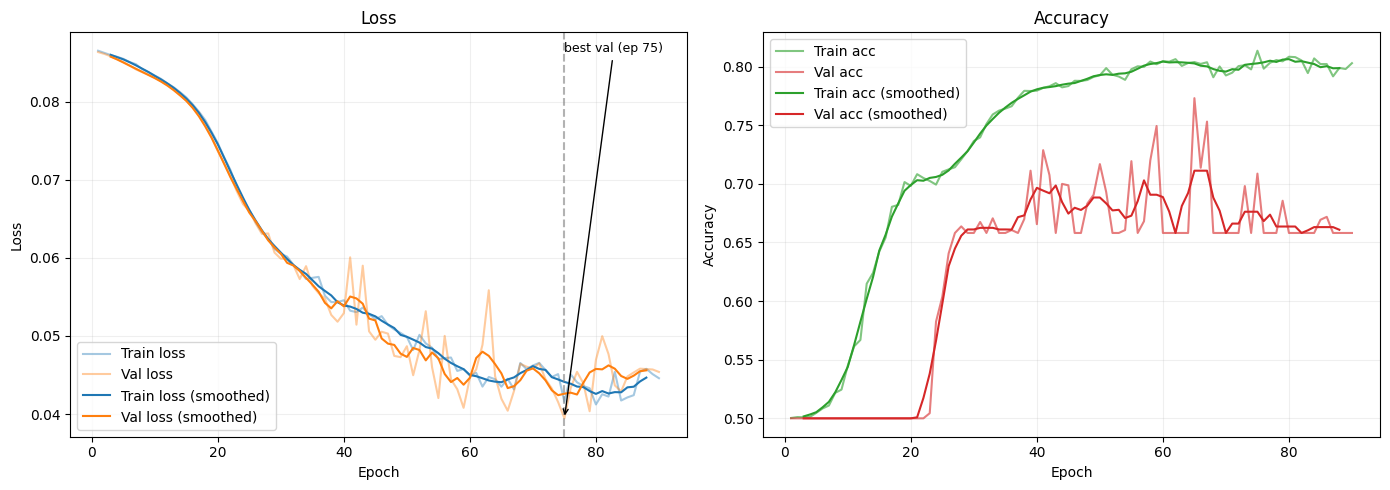

In [24]:
try:
    tr_loss = np.array(train_losses)
    val_loss = np.array(val_losses)
    tr_acc = np.array(train_accs)
    val_acc = np.array(val_accs)
except NameError:
    tr_loss = np.load("train_losses.npy")
    val_loss = np.load("val_losses.npy")
    tr_acc = np.load("train_accs.npy")
    val_acc = np.load("val_accs.npy")

epochs = np.arange(1, len(tr_loss) + 1)

def smooth(x, window=5):
    if len(x) < window:
        return x
    return np.convolve(x, np.ones(window)/window, mode="valid")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss subplot
axes[0].plot(epochs, tr_loss, label="Train loss", color="tab:blue", alpha=0.4)
axes[0].plot(epochs, val_loss, label="Val loss", color="tab:orange", alpha=0.4)
# Smoothed
s_tr = smooth(tr_loss, window=5)
s_val = smooth(val_loss, window=5)
offset = (len(epochs) - len(s_tr)) // 2
axes[0].plot(epochs[offset:offset+len(s_tr)], s_tr, label="Train loss (smoothed)", color="tab:blue")
axes[0].plot(epochs[offset:offset+len(s_val)], s_val, label="Val loss (smoothed)", color="tab:orange")
best_epoch = int(np.argmin(val_loss)) + 1
axes[0].axvline(best_epoch, color="gray", linestyle="--", alpha=0.6)
axes[0].annotate(f"best val (ep {best_epoch})", xy=(best_epoch, val_loss[best_epoch-1]),
                 xytext=(best_epoch, max(val_loss)), arrowprops=dict(arrowstyle="->"), fontsize=9)
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(alpha=0.2)

# Accuracy subplot
axes[1].plot(epochs, tr_acc, label="Train acc", color="tab:green", alpha=0.6)
axes[1].plot(epochs, val_acc, label="Val acc", color="tab:red", alpha=0.6)
s_tr_acc = smooth(tr_acc, window=5)
s_val_acc = smooth(val_acc, window=5)
axes[1].plot(epochs[offset:offset+len(s_tr_acc)], s_tr_acc, label="Train acc (smoothed)", color="tab:green")
axes[1].plot(epochs[offset:offset+len(s_val_acc)], s_val_acc, label="Val acc (smoothed)", color="tab:red")
axes[1].set_title("Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(alpha=0.2)

plt.tight_layout()